# Data Mining Final - Assignment 1 - Group 1

## Problem Definition

Heart disease remains one of the leading killers around the world, responsible for some 18 million deaths per year - or approximately a third of all human lives (World Health Organization, 2021). According to the WHO, early detection and prevention are key to reducing its prevalence as well as the resulting burden of healthcare. While many previous studies have sought to evaluate risk factors - such as lifestyle, genetic, and environmental. There remains a significant opportunity to enhance predictive models and identify previously unrecognized associations. This project aims to build on associations with health data to better understand links between heart disease and general health. 

This project contains 2 datasets from the year (2020 and 2022) containing total over 200k records each, and contains heart disease data. These datasets cover patient demographic characteristics, clinical history including lifestyle factors and biometric measurements. The goal is to identify patterns and relationships that can help enhance our interpretation of risk factors for heart disease, ultimately allowing more accurate predictive models. 

By leveraging factors that are significantly associated with heart disease through data analysis and machine learning algorithms, heath care practicinors can develop better insight into risks of developing the condition.

Reference 
World Health Organization. (2021). Cardiovascular diseases (CVDs). https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)

## Data Preperation

### Importing The Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Load the dataset
data = pd.read_csv('heart_2020_cleaned.csv')

data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


### Insert Into Mongo

In [2]:
from pymongo import MongoClient
import json

# Establish a connection to MongoDB
client = MongoClient('mongodb://localhost:27017/')  # Replace with your MongoDB URI
db = client['heart_disease_db']
collection = db['heart_disease_collection']

# Convert DataFrame to JSON
data_json = json.loads(data.to_json(orient='records'))

# Insert data into MongoDB collection
collection.insert_many(data_json)

# Verify insertion
print("Data inserted into MongoDB collection.")


Data inserted into MongoDB collection.


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

### Missing Values and Duplicates

In [4]:
# Check for missing values
missing_values = data.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64


In [5]:
# Check for duplicates
duplicates = data.duplicated().sum()
print("Number of duplicate rows:", duplicates)

if duplicates > 0:
    data = data.drop_duplicates()
    print(f"Removed {duplicates} duplicate rows.")
else:
    print("No duplicate rows found.")

Number of duplicate rows: 18078
Removed 18078 duplicate rows.


There were no missing values to remove, but if there were any it is safe to drop the rows since the datasets that we are using is very large we can afford to drop a few thousand. The same is done with the duplicate rows that are present within the dataset.

### Outliers

### Z - Score

In [7]:
# Z-score method for outliers in BMI
from scipy import stats

z_scores = np.abs(stats.zscore(data['BMI']))
outliers_z_indices = np.where(z_scores > 3)
outliers_z = data.iloc[outliers_z_indices[0]]
print(f"Outliers detected using Z-score method for BMI: {len(outliers_z_indices[0])}")

Outliers detected using Z-score method for BMI: 3722


### IQR

In [8]:
# Calculate IQR for BMI
Q1 = data['BMI'].quantile(0.25)
Q3 = data['BMI'].quantile(0.75)
IQR = Q3 - Q1

# Determine outliers based on IQR
outliers_iqr = data[(data['BMI'] < (Q1 - 1.5 * IQR)) | (data['BMI'] > (Q3 + 1.5 * IQR))]
print(f"Outliers detected using IQR method for BMI: {outliers_iqr.shape[0]}")

Outliers detected using IQR method for BMI: 8905


### Plotting to Compare

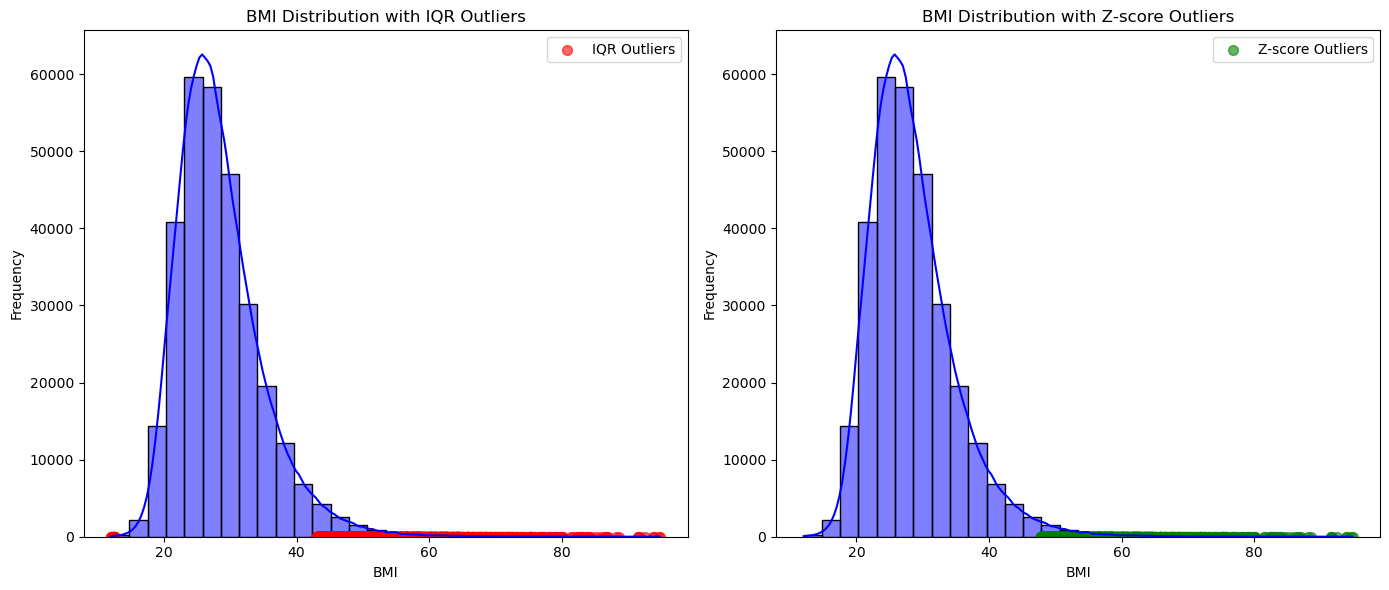

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Plotting
plt.figure(figsize=(14, 6))

# Plot for IQR method
plt.subplot(1, 2, 1)
sns.histplot(data['BMI'], kde=True, color='blue', bins=30)
plt.scatter(outliers_iqr['BMI'], np.zeros_like(outliers_iqr['BMI']), color='red', label='IQR Outliers', s=50, alpha=0.6)
plt.title('BMI Distribution with IQR Outliers')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.legend()

# Plot for Z-score method
plt.subplot(1, 2, 2)
sns.histplot(data['BMI'], kde=True, color='blue', bins=30)
plt.scatter(outliers_z['BMI'], np.zeros_like(outliers_z['BMI']), color='green', label='Z-score Outliers', s=50, alpha=0.6)
plt.title('BMI Distribution with Z-score Outliers')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

IQR is the method that is chosen because it also catches the outliers on the lower end compared to Z - Score only reaching the higher value outliers. IQR generates a more fair and balanced distribution.

### Capping The Outliers

In [ ]:
# Cap outliers in BMI
cap_upper = Q3 + 1.5 * IQR
cap_lower = Q1 - 1.5 * IQR

data['BMI'] = np.where(data['BMI'] > cap_upper, cap_upper, 
                       np.where(data['BMI'] < cap_lower, cap_lower, data['BMI']))

# Verify capping
print(data['BMI'].describe())

count    301717.000000
mean         28.274089
std           5.903722
min          12.600000
25%          24.030000
50%          27.410000
75%          31.650000
max          43.080000
Name: BMI, dtype: float64


### Binning and Discretizing

In [ ]:
# Discretize SleepTime into bins
bins = [0, 4, 6, 8, 10, 15]
labels = ['<4 hours', '4-6 hours', '6-8 hours', '8-10 hours', '10+ hours']
data['SleepTimeCategory'] = pd.cut(data['SleepTime'], bins=bins, labels=labels)

print(data[['SleepTime', 'SleepTimeCategory']].head())

   SleepTime SleepTimeCategory
0        5.0         4-6 hours
1        7.0         6-8 hours
2        8.0         6-8 hours
3        6.0         4-6 hours
4        8.0         6-8 hours


The data is binned into categories based on their sleep schedule as that groups them with many others inside of the same risk categories.

In [ ]:
# Example: Encode 'Sex' column
label_encoder = LabelEncoder()
data['SexEncoded'] = label_encoder.fit_transform(data['Sex'])
print(data[['Sex', 'SexEncoded']].head())

      Sex  SexEncoded
0  Female           0
1  Female           0
2    Male           1
3  Female           0
4  Female           0
